## Vmax tracking using IBTrACS

v05: Here, Rmax is never observed, thus 

X = [Vmax, Rmax_CK, R34, f, U, V] is of size 6

Y = [Vmax, R34, f, U, V] is of size 5

H and R have size 5 x 5

In [1]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# # from matplotlib.colors import Normalize
# # from matplotlib.colors import ListedColormap
# # import matplotlib.cm as cm
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
from torch.autograd import Variable              # Convert arrays to tensors
from torch.utils.data import Dataset, DataLoader # Create a Dataset class to combine with DataLoader (= mini batches selection)
import pytorch_lightning as pl

# Data treatment
# import dask as da
# from dask.diagnostics import ProgressBar
# import zarr
# from scipy.interpolate import griddata
from datetime import datetime
from sklearn.linear_model import LinearRegression

# Custom
import functions as f

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
### Setup device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
print('{} GPU(s) available'.format(torch.cuda.device_count()))

Using cuda device
1 GPU(s) available


In [3]:
### VARIABLES TO CONSIDER
'''Initial dataset has 147 variables, so we select only a subset of these'''
# storm speed, time, dist2land, usa_r64, usa_r50
params_of_interest = ['usa_lon', 'usa_lat', 'usa_wind', 'usa_r34', 'usa_rmw', 'storm_speed', 'storm_dir'] 
additional_info    = ['numobs', 'sid', 'basin', 'name', 'usa_agency', 'iso_time', 'usa_status']

### PARAMS
PARAMS = {'fcor_boost' : 1,         
         }

### PATHS
PATHS  = {
    # Data
    'ibtracs_data': '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc', # '/home/arthur/data/ibtracs/IBTrACS.NA.v04r00.nc'
    # Save
    'save_path':     '/home/arthur/results/TCsLifeMonitFromObs/kalman/',
    'save_csv_path': '/home/arthur/results/TCsLifeMonitFromObs/kalman/csv_files/',
}

In [4]:
### OPEN DATASET
ds_ibt_raw = xr.open_dataset(PATHS['ibtracs_data'])
ds_ibt     = ds_ibt_raw[params_of_interest + additional_info]
# ds_ibt_raw

In [5]:
### FILTERS
# Convert to m/s and km units
ds_ibt['usa_wind']    *= 0.5144
ds_ibt['storm_speed'] *= 0.5144
ds_ibt['usa_r34']     *= 1.852
ds_ibt['usa_rmw']     *= 1.852

### 1) FILTERS BY YEAR, EMPTY R34, CATEGORY, RMAX INTERESTING TIME SERIES
# By year
start_date = np.datetime64('2000-01-01')
fsi        = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt     = ds_ibt.isel(storm=slice(fsi, -1))
# Average by quadrant (R34 assumption)
ds_ibt     = ds_ibt.mean(dim='quadrant', skipna=True)
# By category
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_wind']
    if da.max(dim='date_time', skipna=True) < 33: # >= Cat.1 according to Saffir Simpson scale, 64 is in knts
        ds_ibt.isel(storm=s)['usa_wind'] *= np.nan  

# # Keep only interesting time series, i.e containing sufficiently long sequences of valid Rmax values
for s in tqdm(range(len(ds_ibt['storm']))):
    da = ds_ibt.isel(storm=s)['usa_rmw']
    # Longest valid sequence
    # if np.max(np.diff(np.where(np.isnan(da)))) < 8: # Count maximum valid sequence and filter it out if less than 1 day
    #     ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan
    # Number of valid values
    if np.count_nonzero(~np.isnan(da)) < 24: # Count the number of valid usa_rmw values and filter it out if less than 24 values
        ds_ibt.isel(storm=s)['usa_rmw'] *= np.nan   
# Drop NaNs
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_wind']) # Much quicker to drop NaNs only at the end
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (1): ", len(ds_ibt['storm']))

### 2) FINAL DATASET
### Keep longest valid sequence if it represents more than 60% of the TC life cycle
# Both for RMW and R34
life_cyc_percent_thresh = 0.6

for s in tqdm(range(len(ds_ibt['storm']))):
        ds      = ds_ibt.isel(storm=s)
        # Compute life cycle length
        cyc_len = np.where(np.isnan(ds['usa_lat']))[0][0]
        for param in ['usa_r34', 'usa_rmw']:
            # Compute length of longest valid sequence
            val_len = np.max(np.diff(np.concatenate(([0], np.where(np.isnan(ds[param]))[0]), axis=0)))
            if val_len < life_cyc_percent_thresh * cyc_len:
                # print('Index {}, Cyc_len = {}, val_len = {}'.format(s, cyc_len, val_len))
                ds[param] *= np.nan
                
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_rmw']) 
ds_ibt = ds_ibt.dropna(dim='storm', how='all', subset=['usa_r34'])

print("Total samples after (2): ", len(ds_ibt['storm'])) 

### 3) ADD CORIOLIS
ds_ibt['fcor'] = f.coriolis(np.abs(ds_ibt['usa_lat'])) * PARAMS['fcor_boost']
                
### 4) FLIP TCs of Southern hemisphere
### Take the symmetric with respect to Equator
### So storm_dir = PI - storm_dir
ds_ibt.where(ds_ibt['lat'] < 0)['storm_dir'] = 180 - ds_ibt['storm_dir']
# Then project to (u, v) ref.
ds_ibt['u_trans'] = ds_ibt['storm_speed'] * np.sin(np.deg2rad(ds_ibt['storm_dir']))
ds_ibt['v_trans'] = ds_ibt['storm_speed'] * np.cos(np.deg2rad(ds_ibt['storm_dir']))
# plt.hist(np.array(ds_ibt['u_trans']).flatten()) # Check gaussianity

### 5) COMPUTE RMAX_CK22
ds_ibt['rmax_ck22'] = f.get_rmax_ck22(
    Vmax=ds_ibt['usa_wind'], R17=ds_ibt['usa_r34'], fcor=f.coriolis(np.abs(ds_ibt['usa_lat'])), 
    intercept=0.459, coef1=0.00534, coef2=-0.00337
) / 1000

100%|███████████████████████████████████████| 394/394 [00:00<00:00, 1111.08it/s]


Total samples after (1):  143


100%|████████████████████████████████████████| 143/143 [00:00<00:00, 778.70it/s]


Total samples after (2):  110


In [6]:
# ### SAVE CSV FILES
# for s in range(len(ds_ibt.storm)):
#     ds         = ds_ibt.isel(storm=slice(s, s + 1))
#     filename   = str(ds['name'].values)[2:-1] + '_' + str(ds['sid'].values)[2:-1]
#     X_TC, _    = f.create_Xt_1_and_Xt_full(ds)
#     X_TC       = X_TC[:, [0, 2, 3, 4, 5, 6]] # Scen. 2
#     df         = pd.DataFrame(X_TC)
#     df.columns = ['Vmax', 'Rmax_CK22', 'R34', 'fcor', 'u_trans', 'v_trans']
#     df.to_csv(PATHS['save_csv_path'] + filename, index=False)

In [7]:
### CREATE FULL DATASET
Xt_full, Xt_1_full  = f.create_Xt_1_and_Xt_full(ds_ibt)

### CREATE SCENARIO DATASETS AND INITIALIZE FILTER PARAMS
scen_nb = 4
colors  = ['blue', 'red', 'green', 'orange']
labels  = ['0) Ref. scenario', '1) TC motion scenario', '2) Rmax_CK22 scenario', '3) Derivatives scenario']

REG_MLR = [LinearRegression(fit_intercept=False)        for i in range(scen_nb)]
SCEN    = [{'M': None, 'Q': None, 'H': None, 'R': None,
            'X': None, 'Y': None, 'mask': None, 
            'x_ini': None, 'P_ini': None,
           }                                            for i in range(scen_nb)]
Xt      = [None                                         for i in range(scen_nb)]
Xt_1    = [None                                         for i in range(scen_nb)]

# Create scenario datasets
### 0) REF. SCENARIO ==> X = [Vmax, Rmax, R34, fcor]
Xt[0]   = Xt_full[:, [0, 1, 3, 4]]
Xt_1[0] = Xt_1_full[:, [0, 1, 3, 4]]
### 1) TC MOTION SCENARIO ==> X = [Vmax, Rmax, R34, fcor, u, v]
Xt[1]   = Xt_full[:, [0, 1, 3, 4, 5, 6]]
Xt_1[1] = Xt_1_full[:, [0, 1, 3, 4, 5, 6]]
### 2) RMAX_CK22 SCENARIO ==> X = [Vmax, Rmax_CK22, R34, fcor, u, v]
Xt[2]   = Xt_full[:, [0, 2, 3, 4, 5, 6]]
Xt_1[2] = Xt_1_full[:, [0, 2, 3, 4, 5, 6]]
### 3) DERIVATIVES SCENARIO ==> X = [Vmax, Rmax_CK22, R34, fcor, u, v, Vmax_diff, Rmax_CK22_diff, R34_diff, fcor_diff, u_diff, v_diff]
# Xt[3]   = Xt_full[:, [0,   2, 3, 4, 5, 6, 7,   9, 10, 11, 12, 13]] # with all the derivatives - don't forget to change the KF instance in the next cell!
# Xt_1[3] = Xt_1_full[:, [0,   2, 3, 4, 5, 6, 7,   9, 10, 11, 12, 13]]
Xt[3]   = Xt_full[:, [0,   2, 3, 4, 5, 6, 7]] # with vmax_diff only
Xt_1[3] = Xt_1_full[:, [0,   2, 3, 4, 5, 6, 7]]

# Initialize Filter parameters
for s in range(scen_nb):
    REG_MLR[s].fit(Xt_1[s], Xt[s])
    SCEN[s]['M'] = REG_MLR[s].coef_
    SCEN[s]['Q'] = np.cov((Xt[s] - REG_MLR[s].predict(Xt_1[s])).T)
    SCEN[s]['H'] = np.zeros((REG_MLR[s].coef_.shape[0] - 1, REG_MLR[s].coef_.shape[0]))
    SCEN[s]['H'][0, 0] = 1
    for i in range(1, REG_MLR[s].coef_.shape[0] - 1):
        SCEN[s]['H'][i, i + 1] = 1
    SCEN[s]['R'] = 0.1 * np.diag(np.nanstd(np.delete(Xt_1[s], obj=1, axis=1), axis=0)) # We delete the Rmax colum, which is always the 2nd one.
    SCEN[s]['P_ini'] = 0.1 * np.diag(np.nanstd(Xt_1[s], axis=0))
    # print('\nScenario n°{} ---------------------'.format(s))
    # print('M = \n' + str(np.around(SCEN[s]['M'], 2)))
    # print('Q = \n' + str(np.around(SCEN[s]['Q'], 2)))

100%|█████████████████████████████████████████| 110/110 [00:03<00:00, 35.85it/s]


In [8]:
# np.around(STATE_SPACE_MOD[0]['params'].observation_matrices, 1)

In [9]:
# np.around(STATE_SPACE_MOD[s]['params'].observation_covariance, 2)

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 25.18it/s]


EM optimization for scenario n°0
EM optimization for scenario n°1
EM optimization for scenario n°2
EM optimization for scenario n°3


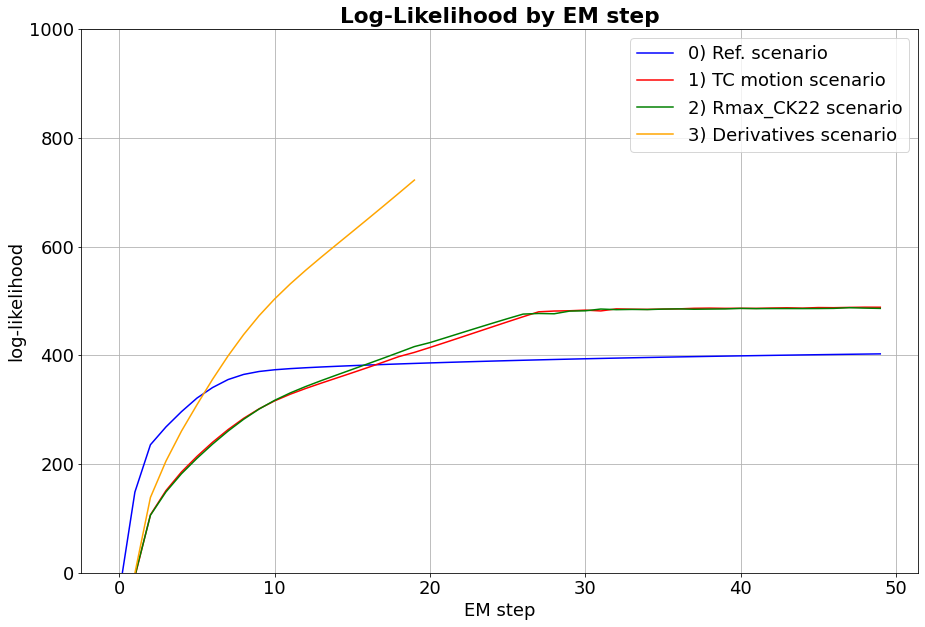


METRICS

0) Ref. scenario (blue)
Vmax Log-likelihood = -55.23
Vmax RMSE(x_s, Y)   = 0.10
Vmax RMSE(x_a, Y)   = 0.09

1) TC motion scenario (red)
Vmax Log-likelihood = -66.55
Vmax RMSE(x_s, Y)   = 0.03
Vmax RMSE(x_a, Y)   = 0.02

2) Rmax_CK22 scenario (green)
Vmax Log-likelihood = -65.60
Vmax RMSE(x_s, Y)   = 0.03
Vmax RMSE(x_a, Y)   = 0.02

3) Derivatives scenario (orange)
Vmax Log-likelihood = 972704.16
Vmax RMSE(x_s, Y)   = 0.00
Vmax RMSE(x_a, Y)   = 0.00

0) Ref. scenario (blue)
Estimated M:
[[ 0.96 -0.03  0.01  0.  ]
 [-0.33  0.72  0.1  -0.  ]
 [-0.01  0.03  1.02  0.  ]
 [ 0.    0.    0.    0.  ]]
Estimated Q:
[[ 4.8000e-01 -1.2740e+01  4.4000e-01 -0.0000e+00]
 [-1.2740e+01  5.4634e+02  4.1630e+01  0.0000e+00]
 [ 4.4000e-01  4.1630e+01  1.1601e+02  0.0000e+00]
 [-0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00]]
Estimated R:
[[ 3.000e-02  5.800e-01 -0.000e+00]
 [ 5.800e-01  3.788e+01 -0.000e+00]
 [-0.000e+00 -0.000e+00  0.000e+00]]

1) TC motion scenario (red)
Estimated M:
[[ 0.96 

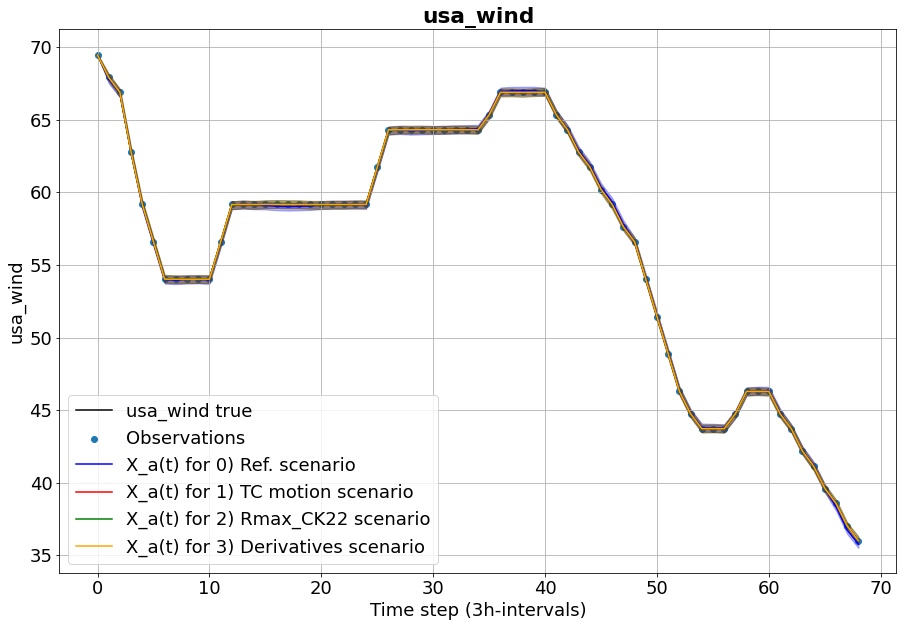

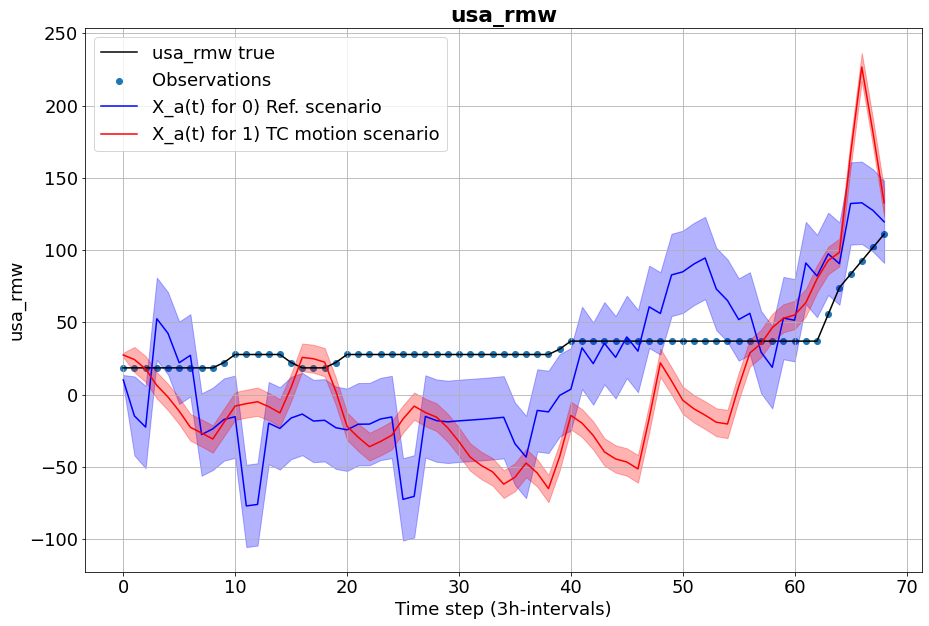

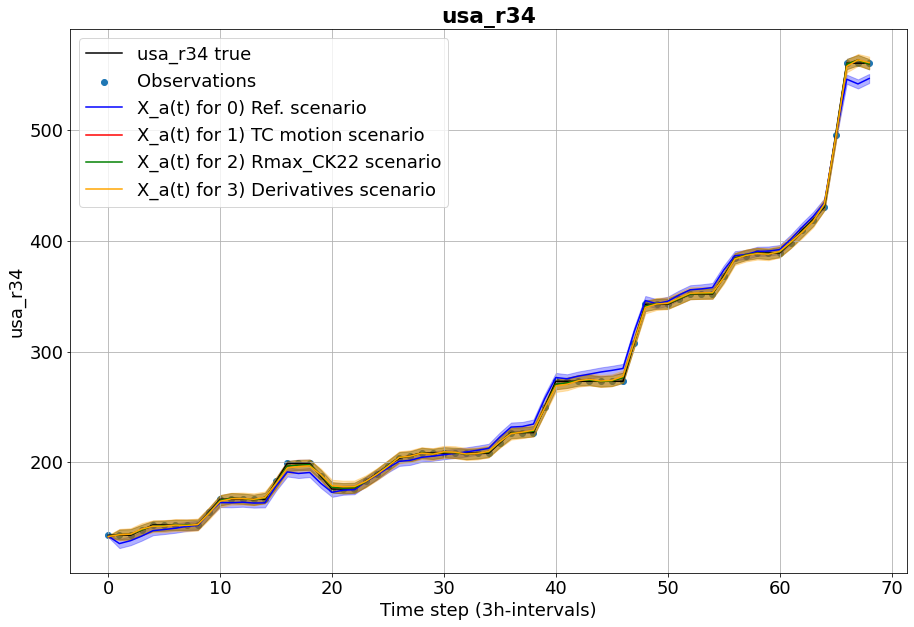

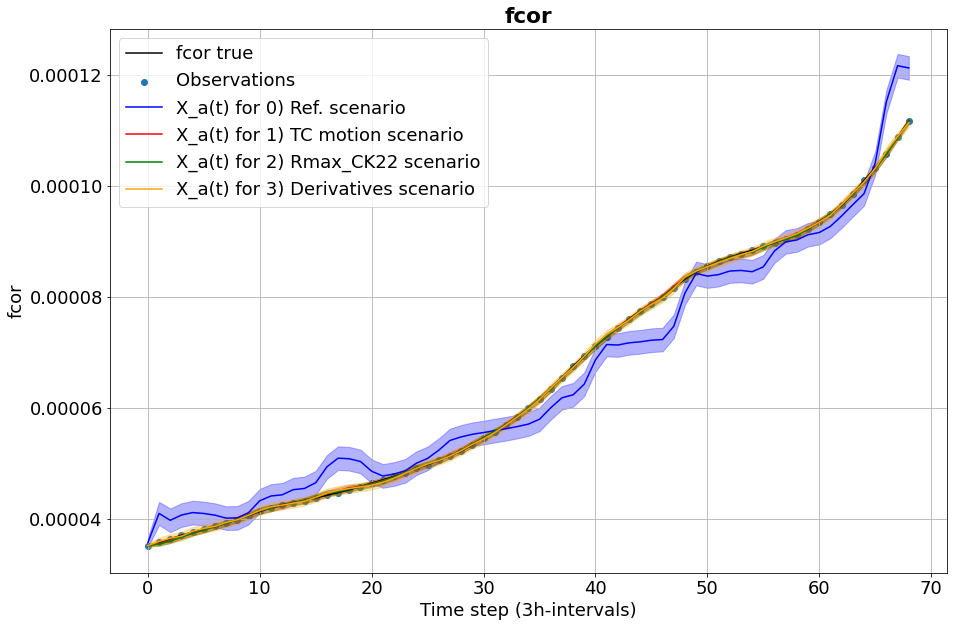

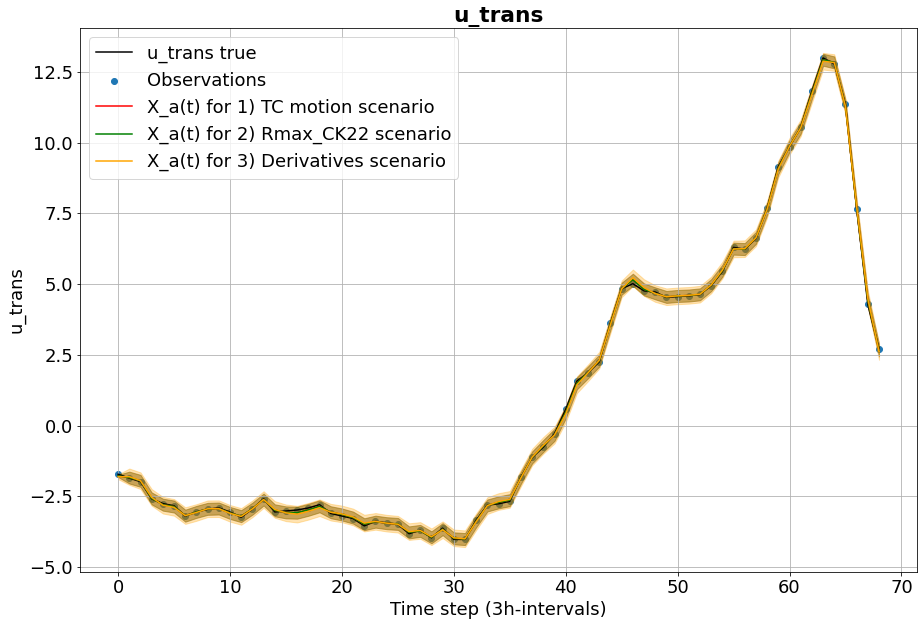

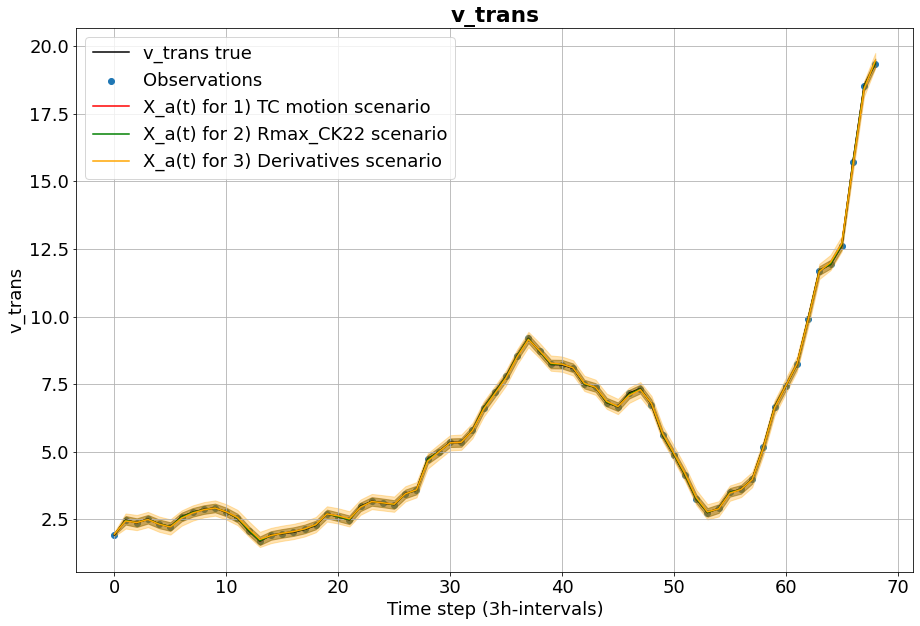

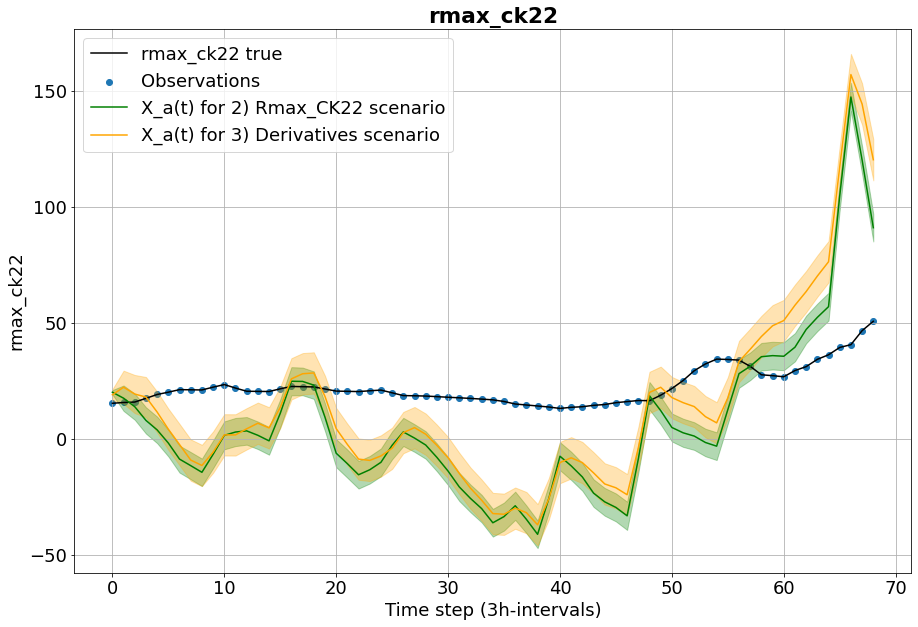

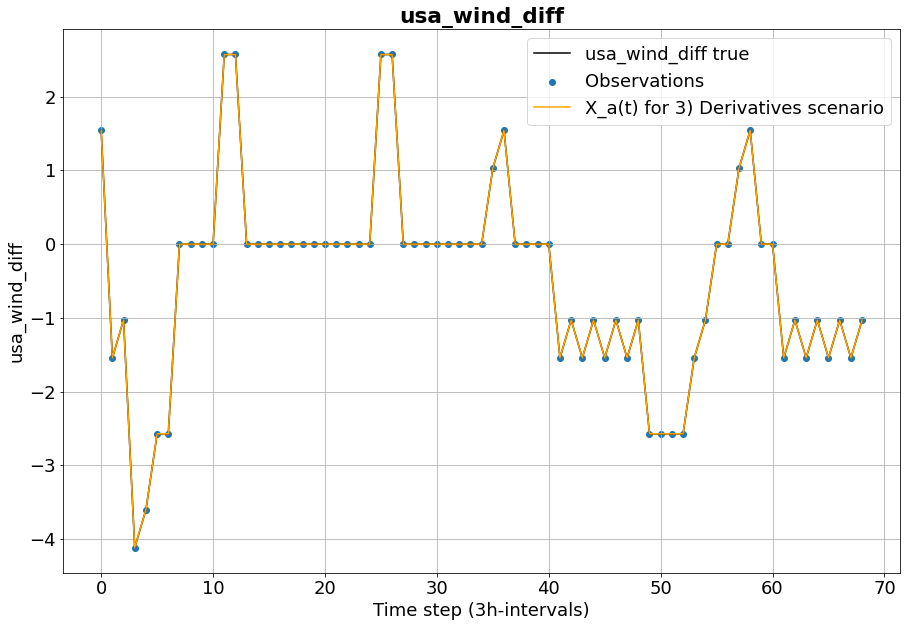

IndexError: index 7 is out of bounds for axis 1 with size 7

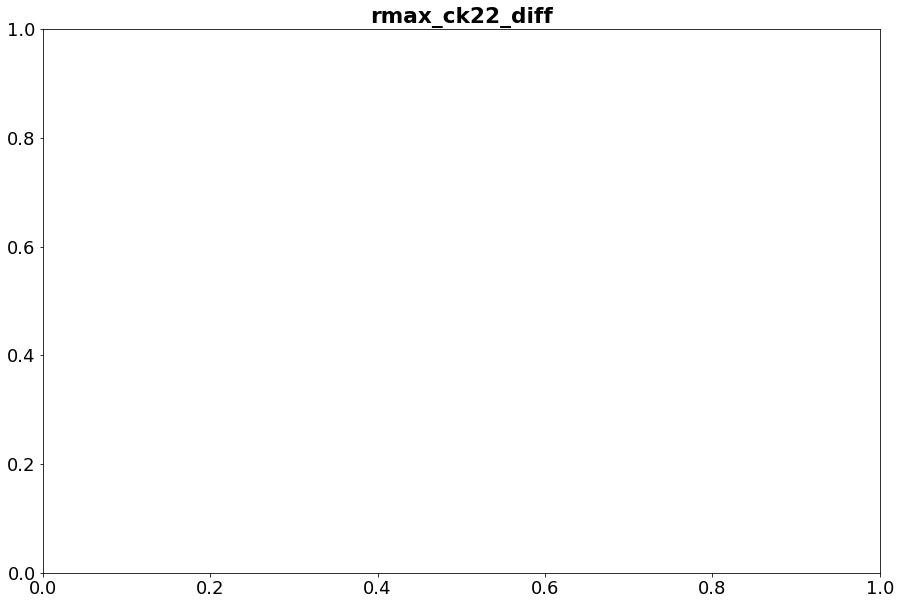

In [10]:
### CREATE NOISY OBSERVATIONS
# Dorian = 88
# Sam    = 109
k         = 109 # 5, 6, 7
ds0       = ds_ibt.isel(storm=slice(k, k + 1))
X_full, _ = f.create_Xt_1_and_Xt_full(ds0)
X_full    = X_full[26:, :]
obs_step  = 1
em_vars   = ['initial_state_mean', 'initial_state_covariance', 'transition_matrices', 'transition_covariance', 'observation_covariance']
# em_vars   = ['initial_state_mean', 'initial_state_covariance', 'transition_matrices', 'observation_covariance']
# transition_covariance makes EM algorithm fail (linalg error because of values too close to 0) for scenario 3.

STATE_SPACE_MOD = [{'params': None, 
                    'x_a': None, 'P_a': None,
                    'x_s': None, 'P_s': None,
                    'x_f': None, 'P_f': None,
                    'loglik': None, 'loglikvmax': None
                   } for i in range(scen_nb)]

### 0) REF. SCENARIO      ==> X = [Vmax, Rmax, R34, fcor]
SCEN[0]['X'] = copy.deepcopy(X_full[:, [0, 1, 3, 4]])
### 1) TC MOTION SCENARIO ==> X = [Vmax, Rmax, R34, fcor, u, v]
SCEN[1]['X'] = copy.deepcopy(X_full[:, [0, 1, 3, 4, 5, 6]])
### 2) RMAX_CK22 SCENARIO ==> X = [Vmax, Rmax_CK22, R34, fcor, u, v]
SCEN[2]['X'] = copy.deepcopy(X_full[:, [0, 2, 3, 4, 5, 6]])
### 3) DERIVATIVES SCENARIO ==> X = [Vmax, Rmax_CK22, R34, fcor, u, v, Vmax_diff, Rmax_CK22_diff, R34_diff, fcor_diff, u_diff, v_diff]
# SCEN[3]['X'] = copy.deepcopy(X_full[:, [0,   2, 3, 4, 5, 6, 7,   9, 10, 11, 12, 13]]) # with all the derivatives - don't forget to change hthe dataset in previous cell!
SCEN[3]['X'] = copy.deepcopy(X_full[:, [0,   2, 3, 4, 5, 6, 7]]) # with vmax_diff only 

# Kalman
for s in range(scen_nb):
    SCEN[s]['Y']    = np.delete(SCEN[s]['X'], obj=1, axis=1)
    SCEN[s]['mask'] = np.ones_like(SCEN[s]['Y'])   # Mask where 1, keep where 0
    SCEN[s]['mask'][::obs_step, :] = 0             # Keep every 4th observation
    # SCEN[s]['mask'][1:, 1] = 1                     # Always mask Rmax
    SCEN[s]['Y']    = np.ma.masked_array(SCEN[s]['Y'], mask=SCEN[s]['mask']) # Mask every value where mask = 1
    SCEN[s]['x_ini']= SCEN[s]['X'][0, :]
    # Kalman filter
    STATE_SPACE_MOD[s]['params'] = KalmanFilter(
        initial_state_mean=SCEN[s]['x_ini'],
        initial_state_covariance=SCEN[s]['P_ini'], 
        transition_matrices=SCEN[s]['M'],
        transition_covariance=SCEN[s]['Q'], 
        observation_matrices=SCEN[s]['H'],
        observation_covariance=SCEN[s]['R'],
        em_vars=em_vars
    )
    # Apply EM algorithm to tune x(0), P(0), M, Q and R
    '''n_iter may be hard to tune:
     All leading minors of positive definite matrix are positive. If n_iter is too big, we will get an error message 
     meaning that the matrix is not positive definite. It may be either indefinite (i.e. have both positive and negative eigenvalues)
     OR it may be near singular, i.e. its smallest eigenvalue is very close to 0 (and so computationally it is 0).'''
    print('EM optimization for scenario n°{}'.format(s))
    if s != 3:
        STATE_SPACE_MOD[s]['params'],  STATE_SPACE_MOD[s]['loglik'] = f.em_optimization(STATE_SPACE_MOD[s]['params'], SCEN[s]['Y'], n_iter=50)
    else: # More EM iterations for scenario 3 (with derivatives)
        STATE_SPACE_MOD[s]['params'],  STATE_SPACE_MOD[s]['loglik'] = f.em_optimization(STATE_SPACE_MOD[s]['params'], SCEN[s]['Y'], n_iter=20)
    # Apply Kalman filter and smoother with these optimized parameters
    STATE_SPACE_MOD[s]['x_a'], STATE_SPACE_MOD[s]['P_a'] = STATE_SPACE_MOD[s]['params'].filter(SCEN[s]['Y'])
    STATE_SPACE_MOD[s]['x_s'], STATE_SPACE_MOD[s]['P_s'] = STATE_SPACE_MOD[s]['params'].smooth(SCEN[s]['Y'])
    
#     STATE_SPACE_MOD[s]['params'],  STATE_SPACE_MOD[s]['loglik'] = f.em_optimization(STATE_SPACE_MOD[s]['params'], SCEN[s]['Y'], n_iter=40)
#     # Apply Kalman filter and smoother with these optimized parameters
#     if s == 3:
#         continue
#     STATE_SPACE_MOD[s]['x_a'], STATE_SPACE_MOD[s]['P_a'] = STATE_SPACE_MOD[s]['params'].filter(SCEN[s]['Y'])
#     STATE_SPACE_MOD[s]['x_s'], STATE_SPACE_MOD[s]['P_s'] = STATE_SPACE_MOD[s]['params'].smooth(SCEN[s]['Y'])
# s=3
# STATE_SPACE_MOD[s]['params'].em_vars = ['initial_state_mean', 'initial_state_covariance', 'transition_matrices', 'observation_covariance']
# STATE_SPACE_MOD[s]['params'], ll3 = f.em_optimization(STATE_SPACE_MOD[s]['params'], SCEN[s]['Y'], n_iter=60)
# STATE_SPACE_MOD[s]['loglik'] = np.concatenate((STATE_SPACE_MOD[s]['loglik'], ll3), axis=0)
# # Apply Kalman filter and smoother with these optimized parameters
# STATE_SPACE_MOD[s]['x_a'], STATE_SPACE_MOD[s]['P_a'] = STATE_SPACE_MOD[s]['params'].filter(SCEN[s]['Y'])
# STATE_SPACE_MOD[s]['x_s'], STATE_SPACE_MOD[s]['P_s'] = STATE_SPACE_MOD[s]['params'].smooth(SCEN[s]['Y'])
    
    
# EM Log-likelihood
plt.title('Log-Likelihood by EM step', weight='bold')
for s in range(scen_nb):
    plt.plot(STATE_SPACE_MOD[s]['loglik'], c=colors[s], label=labels[s])
plt.grid();plt.legend()
plt.ylim(0, 1000)
plt.xlabel('EM step');plt.ylabel('log-likelihood')
plt.show()
# Metrics
print('\nMETRICS')
for s in range(scen_nb):
    print('\n' + labels[s] + ' ({})'.format(colors[s]))
    STATE_SPACE_MOD[s]['loglikvmax'], _, _ = f.get_loglikelihood_vmax(param=STATE_SPACE_MOD[s]['params'],
                                                                      x_a=STATE_SPACE_MOD[s]['x_a'], 
                                                                      P_a=STATE_SPACE_MOD[s]['P_a'],
                                                                      Y=SCEN[s]['Y']
                                                                     )
    print('Vmax Log-likelihood = {:.2f}'.format(np.nansum(STATE_SPACE_MOD[s]['loglikvmax'])))
    print('Vmax RMSE(x_s, Y)   = {:.2f}'.format(f.rmse(STATE_SPACE_MOD[s]['x_s'][:, 0], SCEN[s]['Y'][:, 0])))
    print('Vmax RMSE(x_a, Y)   = {:.2f}'.format(f.rmse(STATE_SPACE_MOD[s]['x_a'][:, 0], SCEN[s]['Y'][:, 0])))

# Print the estimated parameters (e.g., Q)
for s in range(scen_nb):
    print('\n' + labels[s] + ' ({})'.format(colors[s]))
    print('Estimated M:')
    print(str(np.around(STATE_SPACE_MOD[s]['params'].transition_matrices, 2)))
    print('Estimated Q:')
    print(str(np.around(STATE_SPACE_MOD[s]['params'].transition_covariance, 2)))
    print('Estimated R:')
    print(str(np.around(STATE_SPACE_MOD[s]['params'].observation_covariance, 2)))

# Plot
final_params = ['usa_wind', 'usa_rmw', 'usa_r34', 'fcor', 'u_trans', 'v_trans']
for i, p in enumerate(final_params):
    plt.title(p, weight='bold')
    plt.plot(SCEN[1]['X'][:, i], c='k', label='{} true'.format(p))
    plt.scatter(np.arange(len(SCEN[1]['X'][:, i])), SCEN[1]['X'][:, i], label='Observations')
    
    for s in range(scen_nb):
    # for s in [0, 3]:
        if p == 'usa_rmw' and s in [2, 3]:
            continue
        if p in ['u_trans', 'v_trans'] and s == 0:
            continue
        plt.plot(STATE_SPACE_MOD[s]['x_a'][:, i], c=colors[s], label='X_a(t) for {}'.format(labels[s]))
        plt.fill_between(np.arange(len(SCEN[1]['X'][:, i])), 
                         STATE_SPACE_MOD[s]['x_a'][:, i] - 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_a'][:, i, i]), 
                         STATE_SPACE_MOD[s]['x_a'][:, i] + 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_a'][:, i, i]), 
                         color=colors[s], 
                         alpha=0.3)
    
    plt.ylabel(p)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()
    
# Plot Rmax_CK22 reconstruction
p = 'rmax_ck22'
i = 1
plt.title(p, weight='bold')
plt.plot(SCEN[2]['X'][:, i], c='k', label='{} true'.format(p))
plt.scatter(np.arange(len(SCEN[2]['X'][:, i])), SCEN[s]['X'][:, i], label='Observations')
for s in [2, 3]:
    plt.plot(STATE_SPACE_MOD[s]['x_a'][:, i], c=colors[s], label='X_a(t) for {}'.format(labels[s]))
    plt.fill_between(np.arange(len(SCEN[2]['X'][:, i])), 
                     STATE_SPACE_MOD[s]['x_a'][:, i] - 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_a'][:, i, i]), 
                     STATE_SPACE_MOD[s]['x_a'][:, i] + 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_a'][:, i, i]), 
                     color=colors[s], 
                     alpha=0.3)
plt.ylabel(p)
plt.xlabel('Time step (3h-intervals)')
plt.legend()
plt.grid()
# plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
plt.show()

# Plot derivatives reconstruction
i_diff = [6, 7, 8, 9, 10, 11]
p_diff = ['usa_wind_diff', 'rmax_ck22_diff', 'usa_r34_diff', 'fcor_diff', 'u_trans_diff', 'v_trans_diff']
for i, p in zip(i_diff, p_diff):
    s      = 3 # Scenario 3
    plt.title(p, weight='bold')
    plt.plot(SCEN[s]['X'][:, i], c='k', label='{} true'.format(p))
    plt.scatter(np.arange(len(SCEN[s]['X'][:, i])), SCEN[s]['X'][:, i], label='Observations')
    plt.plot(STATE_SPACE_MOD[s]['x_a'][:, i], c=colors[s], label='X_a(t) for {}'.format(labels[s]))
    plt.fill_between(np.arange(len(SCEN[s]['X'][:, i])), 
                     STATE_SPACE_MOD[s]['x_a'][:, i] - 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_a'][:, i, i]), 
                     STATE_SPACE_MOD[s]['x_a'][:, i] + 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_a'][:, i, i]), 
                     color=colors[s], 
                     alpha=0.3)
    plt.ylabel(p)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()


In [ ]:
plt.scatter(X_full[:, 0], X_full[:, 1], label='IBTrACS', c=np.arange(X_full.shape[0]), cmap='coolwarm')
plt.scatter(STATE_SPACE_MOD[1]['x_a'][:, 0], STATE_SPACE_MOD[1]['x_a'][:, 1], c='k', label='Kalman X_a')
plt.xlabel('Vmax');plt.ylabel('Rmax')
plt.grid();plt.legend()

In [ ]:
plt.title('SAM 2021', weight='bold')
plt.plot(SCEN[1]['X'][:, 1], c='k', label='Rmax IBTrACS')
plt.plot(SCEN[2]['X'][:, 1], c='g', label='Rmax CK22')
plt.scatter([11, 23, 40, 50, 55], [12, 10, 21, 23, 24], c='r', label='Rmax_SAR')
plt.grid();plt.legend()
plt.xlabel('Time step')
plt.ylabel('Rmax (km)')

In [ ]:
# plt.title('DORIAN 2019', weight='bold')
# plt.plot(SCEN[2]['X'][:, 1], c='k', label='Rmax_CK22')
# plt.scatter([40, 50, 62], [10, 14, 14], c='r', label='Rmax_SAR')
# plt.grid();plt.legend()
# plt.xlabel('Time step')
# plt.ylabel('Rmax (km)')
# plt.ylim(0, 80)

In [51]:
# # Check SAM date_times
# ds = ds_ibt.isel(storm=-1)
# plt.plot(Xt_full[-95:, 0], c='r')
# plt.plot(ds['usa_wind'][36:131])
# plt.grid()

# plt.plot(ds['time'][36:131], ds['usa_wind'][36:131])
# ds['time'][36:131]

In [ ]:
# KALMAN SMOOTHER

# Plot
final_params = ['usa_wind', 'usa_rmw', 'usa_r34', 'fcor', 'u_trans', 'v_trans']
for i, p in enumerate(final_params):
    plt.title(p, weight='bold')
    plt.plot(SCEN[1]['X'][:, i], c='k', label='{} true'.format(p))
    plt.scatter(np.arange(len(SCEN[1]['X'][:, i])), SCEN[1]['X'][:, i], label='Observations')
    
    for s in range(scen_nb):
    # for s in [0, 3]:
        if p == 'usa_rmw' and s in [2, 3]:
            continue
        if p in ['u_trans', 'v_trans'] and s == 0:
            continue
        plt.plot(STATE_SPACE_MOD[s]['x_s'][:, i], c=colors[s], label='X_s(t) for {}'.format(labels[s]))
        plt.fill_between(np.arange(len(SCEN[1]['X'][:, i])), 
                         STATE_SPACE_MOD[s]['x_s'][:, i] - 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_s'][:, i, i]), 
                         STATE_SPACE_MOD[s]['x_s'][:, i] + 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_s'][:, i, i]), 
                         color=colors[s], 
                         alpha=0.3)
    
    plt.ylabel(p)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()
    
# Plot Rmax_CK22 reconstruction
p = 'rmax_ck22'
i = 1
plt.title(p, weight='bold')
plt.plot(SCEN[2]['X'][:, i], c='k', label='{} true'.format(p))
plt.scatter(np.arange(len(SCEN[2]['X'][:, i])), SCEN[s]['X'][:, i], label='Observations')
for s in [2, 3]:
    plt.plot(STATE_SPACE_MOD[s]['x_s'][:, i], c=colors[s], label='X_f(t) for {}'.format(labels[s]))
    plt.fill_between(np.arange(len(SCEN[2]['X'][:, i])), 
                     STATE_SPACE_MOD[s]['x_s'][:, i] - 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_s'][:, i, i]), 
                     STATE_SPACE_MOD[s]['x_s'][:, i] + 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_s'][:, i, i]), 
                     color=colors[s], 
                     alpha=0.3)
plt.ylabel(p)
plt.xlabel('Time step (3h-intervals)')
plt.legend()
plt.grid()
# plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
plt.show()

# Plot derivatives reconstruction
i_diff = [6, 7, 8, 9, 10, 11]
p_diff = ['usa_wind_diff', 'rmax_ck22_diff', 'usa_r34_diff', 'fcor_diff', 'u_trans_diff', 'v_trans_diff']
for i, p in zip(i_diff, p_diff):
    s      = 3 # Scenario 3
    plt.title(p, weight='bold')
    plt.plot(SCEN[s]['X'][:, i], c='k', label='{} true'.format(p))
    plt.scatter(np.arange(len(SCEN[s]['X'][:, i])), SCEN[s]['X'][:, i], label='Observations')
    plt.plot(STATE_SPACE_MOD[s]['x_s'][:, i], c=colors[s], label='X_s(t) for {}'.format(labels[s]))
    plt.fill_between(np.arange(len(SCEN[s]['X'][:, i])), 
                     STATE_SPACE_MOD[s]['x_s'][:, i] - 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_s'][:, i, i]), 
                     STATE_SPACE_MOD[s]['x_s'][:, i] + 1.96 * np.sqrt(STATE_SPACE_MOD[s]['P_s'][:, i, i]), 
                     color=colors[s], 
                     alpha=0.3)
    plt.ylabel(p)
    plt.xlabel('Time step (3h-intervals)')
    plt.legend()
    plt.grid()
    # plt.savefig(PATHS['save_path'] + 'keep1obsOver{}_{}'.format(obs_step, param))
    plt.show()
